In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp -Rf /content/drive/My\ Drive/hw12/real_or_drawing.zip ./
# !unzip -qq real_or_drawing.zip
# !pip install pytorch-model-summary

In [3]:
import numpy as np
import os
from pytorch_model_summary import summary as summary
import random
import time
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
set_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path = '/content/drive/Shared drives/shared drive/hw12'
path = 'e:/p'

# Preparation

## Plot

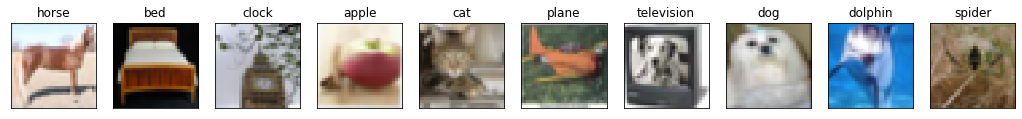

In [4]:
def plot_distribution(pred_labels):
    fig = plt.figure()
    plt.bar(labels_set, counts)
    plt.title(f'Ditribution after {total_epochs}')
    return fig

def no_axis_show(img, title='', cmap=None):
  # imshow, 縮放模式為nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # 不要顯示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  # 注意和subplots的区别，这个方法可以和平常的使用无缝对接
  # 它应该类似于全局设置，而subplots则是单独设置
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

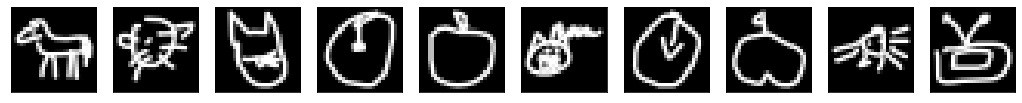

In [5]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

**Canny Edge Detection**

图片素描风格化的库，有两个阈值，low和high，如果高于high，则为阈值，如果高于low低于high，则进一步做判断。

In [6]:
import cv2
import matplotlib.pyplot as plt

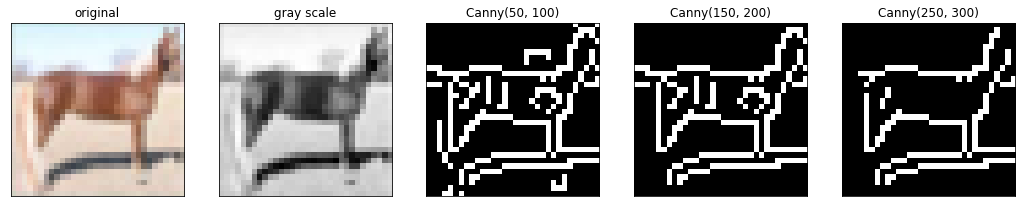

In [7]:
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

In [8]:
type(gray_img)

numpy.ndarray

## Data

对于图像数据，torch有非常好的预处理的API。ImageFolder可以直接输入地址，文件夹是标签，需要提供合适的tensforms。

对于source。
- 转成灰度图像
- 边缘风格化处理，用 transforms.Lambda映射cv2.Canny函数，处理原始图像
- 转为图片，data augment，转tensor

对于target
- 转灰度图
- resize到和source一样大小
- 转为图片，data augment，转tensor

但是对于target上做data augment，我先保留看法，我认为这个会让discriminator更容易辨认，所以extrator的反向操作的强度会加剧，所以应该会然discriminator的loss变大。

In [9]:

source_transform = transforms.Compose([
    # 轉灰階: Canny 不吃 RGB。
    transforms.Grayscale(),
    # cv2 不吃 skimage.Image，因此轉成np.array後再做cv2.Canny
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # cv2.Canny只接受ndarray，且不能是RGB
    # 重新將np.array 轉回 skimage.Image
    transforms.ToPILImage(),
    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15, fill=(0,)),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # 轉灰階: 將輸入3維壓成1維。
    transforms.Grayscale(),
    # 縮放: 因為source data是32x32，我們將target data的28x28放大成32x32。
    transforms.Resize((32, 32)),
    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15, fill=(0,)),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    # 轉灰階: 將輸入3維壓成1維。
    transforms.Grayscale(),
    # 縮放: 因為source data是32x32，我們將target data的28x28放大成32x32。
    transforms.Resize((32, 32)),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])

def get_data_loader(dataset, with_aug = True, mode = 'train', batch_size = 64):
    shuffle = True if mode == 'train' else False
    return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)



In [10]:
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
test_dataset = ImageFolder('real_or_drawing/test_data', transform=test_transform)
source_loader = get_data_loader(source_dataset, mode = 'train')
target_loader = get_data_loader(target_dataset, mode = 'train')
test_loader = get_data_loader(target_dataset, mode = 'eval')

## Model

In [11]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1), #（128，16， 16）
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1), # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1), # (256, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1), # (512, 2, 2)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)                 # (512, 1, 1)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [12]:
def save_model(model, name):
    torch.save(model.state_dict(), os.path.join(path, name))

def load_model(model, name):
    model.load_state_dict(torch.load(os.path.join(path, name),map_location=device) )
    return model

In [13]:
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [14]:
print(summary(feature_extractor, torch.zeros(1, 1, 32, 32).to(device)))
print(summary(label_predictor, torch.zeros(1, 512).to(device)))
print(summary(domain_classifier, torch.zeros(1, 512).to(device)))

------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 64, 32, 32]             640             640
     BatchNorm2d-2      [1, 64, 32, 32]             128             128
            ReLU-3      [1, 64, 32, 32]               0               0
       MaxPool2d-4      [1, 64, 16, 16]               0               0
          Conv2d-5     [1, 128, 16, 16]          73,856          73,856
     BatchNorm2d-6     [1, 128, 16, 16]             256             256
            ReLU-7     [1, 128, 16, 16]               0               0
       MaxPool2d-8       [1, 128, 8, 8]               0               0
          Conv2d-9       [1, 256, 8, 8]         295,168         295,168
    BatchNorm2d-10       [1, 256, 8, 8]             512             512
           ReLU-11       [1, 256, 8, 8]               0               0
      MaxPool2d-12       [1, 256, 4, 4]               0        

## Training

DaNN的训练的理解如下：
- 两条线，第一是对于带标签数据的acc，包含extractor和predictor，另一条线是无标签的source/target二discriminator的acc
- 我们的目标是使得extractor提取的features混合在一起，不能让discriminator简单的分辨出来，最好分辨不出来。
- 于是我们同时训练二者，A step，训练d，让它尽可能分类准，B step，训练e和p，取d的负梯度，让features发生变化，这种变化使得d变得无法分辨
- d会不断地挣扎，A step会让d尽力去从feature中区分source和target， 而B step则总是混淆features，让d准确率降低
- 因为d无法看到feature之前的东西，feature之前的东西不受到d的控制，因而d最后一定会坏掉。

DaNN重要的指标：
- d的loss，或者二分类的acc变化，我们想让它越差越好

先测试一下epoch的影响，由于要使用kaggle，我试试100，200， 300， 400，500三个参数下的大致表现，然后剩下两次用于测试，target data不进行aug，训练的时候aug，测试的时候不aug。

In [15]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: 調控adversarial的loss係數。
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        # batch normlization layer
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 訓練Domain Classifier
        feature = feature_extractor(mixed_data)
        # 因為我們在Step 1不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練Feature Extractor和Predictor
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss為原本的class CE - lamb * domain BCE，相減的原因同GAN中的Discriminator中的G loss
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num


## Testing

In [16]:
def testing(extractor, predictor, loader, return_true_labels = False):
    pred_labels = []
    latents = []
    labels = []
    pred_probs = []
    extractor.to(device)
    predictor.to(device)
    predictor.eval()
    extractor.eval()
    with torch.no_grad():
        for i, (test_data, label) in enumerate(loader):
            test_data = test_data.cuda()
            latent = feature_extractor(test_data)
            class_logits = label_predictor(latent)
            pred_prob = torch.softmax(class_logits, dim = 1).cpu().detach().numpy()
            pred_label = torch.argmax(class_logits, dim=1).cpu().detach().numpy()

            pred_labels.append(pred_label)
            pred_probs.append(pred_prob)
            latents.append(latent.cpu().numpy())
            labels.append(label.numpy())
            
    pred_labels = np.concatenate(pred_labels)
    pred_probs = np.concatenate(pred_probs)
    latents = np.concatenate(latents, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    if return_true_labels == True:
        return pred_labels, pred_probs, latents, labels
    return pred_labels,pred_probs, latents

In [ ]:
import pandas as pd
# testing
set_seed(0)
# model name
epochs_num = 500
ex_name = f'extractor_model_{epochs_num}.bin'
pr_name = f'predictor_model_{epochs_num}.bin'
# data
test_loader = get_data_loader(test_dataset, mode = 'eval')
# load model
feature_extractor = FeatureExtractor().to(device)
label_predictr = LabelPredictor().to(device)
feature_extractor = load_model(feature_extractor, ex_name)
label_predictor = load_model(label_predictor, pr_name)
#predict
pred_labels, pred_probs, latents = testing(feature_extractor, label_predictor, test_loader)
# save
df = pd.DataFrame({'id': np.arange(0,len(pred_labels)), 'label': pred_labels})
df.to_csv(f'DaNN_submission_{ex_name}.csv',index=False)

## Ensemble

这边使用soft voting，实现weighted voting的方式以及hard label的方式。

结果是，直接从61掉到了59，看来前期的模型是太弱了

In [ ]:
def soft_voting(preds, weights = None):
    if weights is None:
        weights = np.ones(len(preds))
    weights = np.array(weights).reshape((-1, 1, 1))
    # print(preds[0].shape)
    preds = np.concatenate([p[np.newaxis,:] for p in preds],axis=0)
    # print(preds.shape)
    preds = np.sum(preds * weights, axis=0)
    # print(preds)
    preds = np.argmax(preds, axis=1)
    return preds

In [ ]:
models = [100, 200, 300, 400, 500]
preds = []
preds_hard = []
for epochs_num in models:
    ex_name = f'extractor_model_{epochs_num}.bin'
    pr_name = f'predictor_model_{epochs_num}.bin'
    # data
    test_loader = get_data_loader(test_dataset, mode = 'eval')
    # load model
    feature_extractor = FeatureExtractor().to(device)
    label_predictr = LabelPredictor().to(device)
    feature_extractor = load_model(feature_extractor, ex_name)
    label_predictor = load_model(label_predictor, pr_name)
    #predict
    pred_labels, pred_probs, latents = testing(feature_extractor, label_predictor, test_loader)
    preds.append(pred_probs)
    preds_hard.append(pred_labels)

In [ ]:
# 100, 0.51349
# 200, 0.49530
# 300, 0.53430
# 400, 0.56480
# 500, 0.59531
weights = [0.51349, 0.49530,0.53430,0.56480, 0.59531]

In [ ]:
preds_ens = soft_voting(preds, weights= weights)

In [ ]:
df = pd.DataFrame({'id': np.arange(0,len(pred_labels)), 'label': preds_ens})
df.to_csv(f'DaNN_submission_{ex_name}.csv',index=False)

## Plot

In [ ]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def cluster(vec, show_plot = False):
  # 选择最佳的维度
  d = 50
  if show_plot:
    pca = PCA()
    pca.fit(vec)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    # d = np.argmax(cumsum>0.99)+1
    print(d, cumsum[d])
    plt.plot(cumsum)
    plt.show()
  tfs = KernelPCA(n_components=d, kernel='rbf')
  vec_1 = tfs.fit_transform(vec)
  print('Fisrt Reduction Shape:{}'.format(vec_1.shape))
  vec_2 = TSNE(n_components=2, random_state=0).fit_transform(vec_1)
  # print("Second Reduction Shape:{}".format(vec_2.shape))
#   labels = MiniBatchKMeans(2, random_state=0).fit(vec_2).labels_
  return vec_2

def plot_scatter(feat, label, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    fig = plt.figure()
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c = label, s =5, alpha=0.5)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    
    return fig

In [ ]:
source_transform_noaug = transforms.Compose([
    # 轉灰階: Canny 不吃 RGB。
    transforms.Grayscale(),
    # cv2 不吃 skimage.Image，因此轉成np.array後再做cv2.Canny
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # cv2.Canny只接受ndarray，且不能是RGB
    # 重新將np.array 轉回 skimage.Image
    transforms.ToPILImage(),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])
source_dataset_noaug = ImageFolder('real_or_drawing/train_data', transform=source_transform_noaug)

In [ ]:
# plot cluster 
import pandas as pd
# testing
set_seed(0)
# model name
epochs_num = 100
ex_name = f'extractor_model_{epochs_num}.bin'
pr_name = f'predictor_model_{epochs_num}.bin'
# data
test_loader = get_data_loader(test_dataset, mode = 'eval')
source_loader = get_data_loader(source_dataset_noaug, mode = 'eval')
# load model
feature_extractor = FeatureExtractor().to(device)
label_predictr = LabelPredictor().to(device)
feature_extractor = load_model(feature_extractor, ex_name)
label_predictor = load_model(label_predictor, pr_name)
#predict
pred_s, latents_s,labels_s = testing(feature_extractor, label_predictor, source_loader, return_true_labels=True)
pred_t, latents_t = testing(feature_extractor, label_predictor, test_loader)
# select idx
select_idx = np.arange(len(latents_t))
np.random.shuffle(select_idx)
select_idx = select_idx[:len(latents_s)]
pred_t, latents_t=pred_t[select_idx], latents_t[select_idx,:]
# dimension reduction
latent_tc = cluster(latents_t, show_plot=True)
latent_sc = cluster(latents_s, show_plot=True)
latent_all = np.concatenate([latent_tc, latent_sc], axis = 0)
labels = np.zeros((len(latent_all),), dtype=np.int32)
labels[len(latent_tc):]=1
fig = plot_scatter(latent_all, labels)

In [ ]:
# plot cluster without adv
import pandas as pd
# testing
set_seed(0)
# model name
epochs_num = 100
ex_name = f'extractor_model_noadv_{epochs_num}.bin'
pr_name = f'predictor_model_noadv_{epochs_num}.bin'
# data
test_loader = get_data_loader(test_dataset, mode = 'eval')
source_loader = get_data_loader(source_dataset_noaug, mode = 'eval')
# load model
feature_extractor = FeatureExtractor().to(device)
label_predictr = LabelPredictor().to(device)
feature_extractor = load_model(feature_extractor, ex_name)
label_predictor = load_model(label_predictor, pr_name)
#predict
pred_s, latents_s,labels_s = testing(feature_extractor, label_predictor, source_loader, return_true_labels=True)
pred_t, latents_t = testing(feature_extractor, label_predictor, test_loader)
# select idx
select_idx = np.arange(len(latents_t))
np.random.shuffle(select_idx)
select_idx = select_idx[:len(latents_s)]
pred_t, latents_t=pred_t[select_idx], latents_t[select_idx,:]
# dimension reduction
latent_tc = cluster(latents_t, show_plot=True)
latent_sc = cluster(latents_s, show_plot=True)
latent_all = np.concatenate([latent_tc, latent_sc], axis = 0)
labels = np.zeros((len(latent_all),), dtype=np.int32)
labels[len(latent_tc):]=1
fig = plot_scatter(latent_all, labels)

## Tem

In [ ]:
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
test_dataset = ImageFolder('real_or_drawing/test_data', transform=test_transform)
source_loader = get_data_loader(source_dataset, batch_size=256, mode = 'train')
target_loader = get_data_loader(target_dataset, batch_size=256, mode = 'train')
test_loader = get_data_loader(test_dataset,batch_size=512, mode = 'eval')

# epoch test 100,200, 300, 400,500
# 100, 0.51349
# 200, 0.49530
# 300, 0.53430
# 400, 0.56480
# 500, 0.59531
# 500, test without aug, 0.61848

set_seed(0)
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# epoch test 100,200, 300, 400,500
source_loader = get_data_loader(source_dataset, mode = 'train')
target_loader = get_data_loader(target_dataset, mode = 'train')
test_loader = get_data_loader(target_dataset, mode = 'eval')
epochs = 1500

for epoch in range(1, epochs+1):
    st = time.time()
    train_D_loss, train_F_loss, train_acc = train_epoch(source_loader, target_loader, lamb=0.1)
    ed = time.time()
    if epoch % 100 == 0:
        save_model(feature_extractor,  f'extractor_model_{epoch}.bin')
        save_model(label_predictor, f'predictor_model_{epoch}.bin')
        save_model(domain_classifier, f'domain_classifier_{epoch}.bin')
        pred_labels, pred_probs,_ = testing(feature_extractor, label_predictor, test_loader)
        df = pd.DataFrame({'id': np.arange(0,len(pred_labels)), 'label': pred_labels})
        df.to_csv(f'DaNN_submission_{epoch}.csv',index=False)

    print('{:4.2f}s, epoch [{:0>3d}\{}]: train D loss: {:6.4f}, train F loss: {:6.6f}, acc {:6.6f}'.format(ed-st, epoch, epochs,  train_D_loss, train_F_loss, train_acc))

5.40s, epoch [001\1500]: train D loss: 0.8902, train F loss: 1.962531, acc 0.243000
5.38s, epoch [002\1500]: train D loss: 0.6804, train F loss: 1.626444, acc 0.395000
5.36s, epoch [003\1500]: train D loss: 0.6368, train F loss: 1.478044, acc 0.452800
5.39s, epoch [004\1500]: train D loss: 0.6202, train F loss: 1.385732, acc 0.484200
5.45s, epoch [005\1500]: train D loss: 0.5201, train F loss: 1.318019, acc 0.515000
5.33s, epoch [006\1500]: train D loss: 0.5349, train F loss: 1.278779, acc 0.538600
5.33s, epoch [007\1500]: train D loss: 0.5456, train F loss: 1.230906, acc 0.544800
5.33s, epoch [008\1500]: train D loss: 0.5257, train F loss: 1.200576, acc 0.564800
5.33s, epoch [009\1500]: train D loss: 0.5452, train F loss: 1.137928, acc 0.580400
5.34s, epoch [010\1500]: train D loss: 0.5172, train F loss: 1.119278, acc 0.593000
5.35s, epoch [011\1500]: train D loss: 0.5367, train F loss: 1.094033, acc 0.600200
5.32s, epoch [012\1500]: train D loss: 0.5161, train F loss: 1.070617, acc 0

5.38s, epoch [099\1500]: train D loss: 0.3644, train F loss: 0.057117, acc 0.969000
5.40s, epoch [100\1500]: train D loss: 0.3736, train F loss: 0.067013, acc 0.963600
5.33s, epoch [101\1500]: train D loss: 0.4257, train F loss: 0.175113, acc 0.928000
5.33s, epoch [102\1500]: train D loss: 0.4048, train F loss: 0.119121, acc 0.948200
5.32s, epoch [103\1500]: train D loss: 0.4150, train F loss: 0.163264, acc 0.933000
5.32s, epoch [104\1500]: train D loss: 0.4230, train F loss: 0.138692, acc 0.940600
5.31s, epoch [105\1500]: train D loss: 0.3856, train F loss: 0.107592, acc 0.951400
5.32s, epoch [106\1500]: train D loss: 0.3888, train F loss: 0.107203, acc 0.951600
5.32s, epoch [107\1500]: train D loss: 0.3813, train F loss: 0.058599, acc 0.970800
5.32s, epoch [108\1500]: train D loss: 0.3824, train F loss: 0.066186, acc 0.965200
5.32s, epoch [109\1500]: train D loss: 0.3890, train F loss: 0.119357, acc 0.950000
5.32s, epoch [110\1500]: train D loss: 0.3955, train F loss: 0.070211, acc 0

5.33s, epoch [197\1500]: train D loss: 0.4457, train F loss: 0.011026, acc 0.982600
5.32s, epoch [198\1500]: train D loss: 0.4297, train F loss: 0.018499, acc 0.981400
5.33s, epoch [199\1500]: train D loss: 0.4233, train F loss: 0.012362, acc 0.982600
5.32s, epoch [200\1500]: train D loss: 0.4311, train F loss: 0.021253, acc 0.978800
5.30s, epoch [201\1500]: train D loss: 0.4321, train F loss: 0.035692, acc 0.975400
5.28s, epoch [202\1500]: train D loss: 0.4292, train F loss: 0.013662, acc 0.982400
5.29s, epoch [203\1500]: train D loss: 0.4297, train F loss: 0.006024, acc 0.984400
5.30s, epoch [204\1500]: train D loss: 0.4377, train F loss: 0.009543, acc 0.985000
5.30s, epoch [205\1500]: train D loss: 0.4525, train F loss: 0.021784, acc 0.978600
5.32s, epoch [206\1500]: train D loss: 0.4270, train F loss: 0.022732, acc 0.977800
5.29s, epoch [207\1500]: train D loss: 0.4395, train F loss: 0.006151, acc 0.983200
5.30s, epoch [208\1500]: train D loss: 0.4330, train F loss: 0.014550, acc 0

5.31s, epoch [295\1500]: train D loss: 0.4570, train F loss: 0.003668, acc 0.984600
5.32s, epoch [296\1500]: train D loss: 0.4640, train F loss: -0.001218, acc 0.985000
5.31s, epoch [297\1500]: train D loss: 0.4384, train F loss: -0.008755, acc 0.989200
5.32s, epoch [298\1500]: train D loss: 0.4526, train F loss: -0.010881, acc 0.990200
5.31s, epoch [299\1500]: train D loss: 0.4591, train F loss: -0.006166, acc 0.988000
5.41s, epoch [300\1500]: train D loss: 0.4655, train F loss: 0.009886, acc 0.983000
5.30s, epoch [301\1500]: train D loss: 0.4524, train F loss: 0.001738, acc 0.985400
5.31s, epoch [302\1500]: train D loss: 0.4646, train F loss: 0.001997, acc 0.984800
5.35s, epoch [303\1500]: train D loss: 0.4472, train F loss: -0.004177, acc 0.986200
5.37s, epoch [304\1500]: train D loss: 0.4429, train F loss: -0.002749, acc 0.987200
5.35s, epoch [305\1500]: train D loss: 0.4435, train F loss: -0.002782, acc 0.986600
5.38s, epoch [306\1500]: train D loss: 0.4618, train F loss: -0.01258

5.29s, epoch [392\1500]: train D loss: 0.4588, train F loss: -0.016961, acc 0.992000
5.28s, epoch [393\1500]: train D loss: 0.4616, train F loss: -0.017881, acc 0.990000
5.29s, epoch [394\1500]: train D loss: 0.4745, train F loss: -0.008878, acc 0.988600
5.28s, epoch [395\1500]: train D loss: 0.4822, train F loss: -0.006250, acc 0.986200
5.28s, epoch [396\1500]: train D loss: 0.4571, train F loss: -0.010853, acc 0.988200
5.28s, epoch [397\1500]: train D loss: 0.4563, train F loss: -0.018130, acc 0.990200
5.29s, epoch [398\1500]: train D loss: 0.4768, train F loss: -0.015385, acc 0.991000
5.30s, epoch [399\1500]: train D loss: 0.4918, train F loss: 0.021676, acc 0.978200
5.28s, epoch [400\1500]: train D loss: 0.4830, train F loss: -0.012567, acc 0.990400
5.28s, epoch [401\1500]: train D loss: 0.4693, train F loss: -0.009581, acc 0.990000
5.27s, epoch [402\1500]: train D loss: 0.4846, train F loss: -0.008088, acc 0.986200
5.27s, epoch [403\1500]: train D loss: 0.4768, train F loss: -0.01

5.36s, epoch [489\1500]: train D loss: 0.4731, train F loss: -0.012729, acc 0.988600
5.36s, epoch [490\1500]: train D loss: 0.4673, train F loss: -0.015470, acc 0.991400
5.37s, epoch [491\1500]: train D loss: 0.4931, train F loss: -0.021865, acc 0.988800
5.32s, epoch [492\1500]: train D loss: 0.4693, train F loss: -0.017299, acc 0.990800
5.27s, epoch [493\1500]: train D loss: 0.5067, train F loss: -0.002545, acc 0.984200
5.27s, epoch [494\1500]: train D loss: 0.4891, train F loss: -0.011560, acc 0.986600
5.27s, epoch [495\1500]: train D loss: 0.4666, train F loss: -0.022928, acc 0.991600
5.26s, epoch [496\1500]: train D loss: 0.4629, train F loss: -0.022368, acc 0.992600
5.27s, epoch [497\1500]: train D loss: 0.4672, train F loss: -0.027265, acc 0.994000
5.59s, epoch [498\1500]: train D loss: 0.4710, train F loss: -0.000575, acc 0.986400
5.33s, epoch [499\1500]: train D loss: 0.4731, train F loss: -0.007037, acc 0.988800
5.28s, epoch [500\1500]: train D loss: 0.4787, train F loss: -0.0

5.24s, epoch [586\1500]: train D loss: 0.5108, train F loss: -0.016745, acc 0.990800
5.24s, epoch [587\1500]: train D loss: 0.4939, train F loss: -0.028695, acc 0.992600
5.24s, epoch [588\1500]: train D loss: 0.4973, train F loss: -0.021261, acc 0.991200
5.23s, epoch [589\1500]: train D loss: 0.4940, train F loss: -0.020806, acc 0.990400
5.25s, epoch [590\1500]: train D loss: 0.4897, train F loss: -0.025263, acc 0.993000
5.23s, epoch [591\1500]: train D loss: 0.5136, train F loss: 0.035266, acc 0.976800
5.23s, epoch [592\1500]: train D loss: 0.4814, train F loss: -0.025632, acc 0.993200
5.24s, epoch [593\1500]: train D loss: 0.4911, train F loss: -0.021348, acc 0.991800
5.25s, epoch [594\1500]: train D loss: 0.4949, train F loss: -0.015876, acc 0.990000
5.23s, epoch [595\1500]: train D loss: 0.4823, train F loss: -0.019856, acc 0.990400
5.24s, epoch [596\1500]: train D loss: 0.4948, train F loss: -0.021294, acc 0.991800
5.25s, epoch [597\1500]: train D loss: 0.4993, train F loss: -0.01

5.23s, epoch [683\1500]: train D loss: 0.5089, train F loss: -0.022102, acc 0.990600
5.25s, epoch [684\1500]: train D loss: 0.4940, train F loss: -0.019578, acc 0.989600
5.23s, epoch [685\1500]: train D loss: 0.4899, train F loss: -0.021297, acc 0.990600
5.24s, epoch [686\1500]: train D loss: 0.5012, train F loss: -0.022954, acc 0.991400
5.24s, epoch [687\1500]: train D loss: 0.4997, train F loss: -0.021038, acc 0.991400
5.23s, epoch [688\1500]: train D loss: 0.5025, train F loss: -0.026829, acc 0.991000
5.23s, epoch [689\1500]: train D loss: 0.5008, train F loss: -0.028648, acc 0.994800
5.22s, epoch [690\1500]: train D loss: 0.5039, train F loss: -0.026495, acc 0.992400
5.22s, epoch [691\1500]: train D loss: 0.5011, train F loss: -0.020413, acc 0.991600
5.23s, epoch [692\1500]: train D loss: 0.5232, train F loss: 0.002130, acc 0.985800
5.24s, epoch [693\1500]: train D loss: 0.5039, train F loss: -0.028878, acc 0.992800
5.24s, epoch [694\1500]: train D loss: 0.5176, train F loss: -0.02

5.24s, epoch [780\1500]: train D loss: 0.5132, train F loss: -0.025073, acc 0.991400
5.24s, epoch [781\1500]: train D loss: 0.5180, train F loss: -0.023732, acc 0.990800
5.24s, epoch [782\1500]: train D loss: 0.5109, train F loss: -0.032665, acc 0.993000
5.25s, epoch [783\1500]: train D loss: 0.5107, train F loss: -0.027011, acc 0.992200
5.25s, epoch [784\1500]: train D loss: 0.4971, train F loss: -0.038187, acc 0.996600
5.25s, epoch [785\1500]: train D loss: 0.5039, train F loss: -0.029494, acc 0.993000
5.26s, epoch [786\1500]: train D loss: 0.5185, train F loss: -0.032532, acc 0.994000
5.26s, epoch [787\1500]: train D loss: 0.5140, train F loss: -0.030116, acc 0.993600
5.25s, epoch [788\1500]: train D loss: 0.5219, train F loss: -0.029123, acc 0.993200
5.27s, epoch [789\1500]: train D loss: 0.5281, train F loss: -0.022815, acc 0.988800
5.27s, epoch [790\1500]: train D loss: 0.5246, train F loss: -0.025436, acc 0.991600
5.27s, epoch [791\1500]: train D loss: 0.5060, train F loss: -0.0

5.27s, epoch [877\1500]: train D loss: 0.5182, train F loss: -0.027385, acc 0.991600
5.26s, epoch [878\1500]: train D loss: 0.5209, train F loss: -0.028811, acc 0.993800
5.29s, epoch [879\1500]: train D loss: 0.5136, train F loss: -0.029681, acc 0.992600
5.29s, epoch [880\1500]: train D loss: 0.5214, train F loss: -0.026597, acc 0.992800
5.30s, epoch [881\1500]: train D loss: 0.5331, train F loss: -0.017772, acc 0.990000
5.28s, epoch [882\1500]: train D loss: 0.5219, train F loss: -0.027684, acc 0.993400
5.26s, epoch [883\1500]: train D loss: 0.5142, train F loss: -0.032120, acc 0.994200
5.26s, epoch [884\1500]: train D loss: 0.5104, train F loss: -0.031014, acc 0.994600
5.27s, epoch [885\1500]: train D loss: 0.5147, train F loss: -0.029444, acc 0.993200
5.26s, epoch [886\1500]: train D loss: 0.5393, train F loss: -0.017134, acc 0.989400
5.27s, epoch [887\1500]: train D loss: 0.5233, train F loss: -0.029957, acc 0.992400
5.27s, epoch [888\1500]: train D loss: 0.5110, train F loss: -0.0

5.25s, epoch [974\1500]: train D loss: 0.5285, train F loss: -0.029129, acc 0.992600
5.25s, epoch [975\1500]: train D loss: 0.5398, train F loss: -0.031335, acc 0.992000
5.25s, epoch [976\1500]: train D loss: 0.5230, train F loss: -0.026537, acc 0.991800
5.25s, epoch [977\1500]: train D loss: 0.5260, train F loss: -0.035304, acc 0.994200
5.25s, epoch [978\1500]: train D loss: 0.5219, train F loss: -0.033460, acc 0.994000
5.25s, epoch [979\1500]: train D loss: 0.5369, train F loss: -0.032442, acc 0.994600
5.25s, epoch [980\1500]: train D loss: 0.5216, train F loss: -0.038471, acc 0.995600
5.24s, epoch [981\1500]: train D loss: 0.5160, train F loss: -0.034684, acc 0.994200
5.25s, epoch [982\1500]: train D loss: 0.5390, train F loss: -0.017325, acc 0.990200
5.28s, epoch [983\1500]: train D loss: 0.5374, train F loss: -0.019995, acc 0.990400
5.25s, epoch [984\1500]: train D loss: 0.5317, train F loss: -0.025430, acc 0.990200
5.26s, epoch [985\1500]: train D loss: 0.5308, train F loss: -0.0

In [ ]:
# train without adversial
set_seed(0)
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# epoch test 100,200, 300, 400,500
source_loader = get_data_loader(source_dataset, mode = 'train')
target_loader = get_data_loader(target_dataset, mode = 'train')
test_loader = get_data_loader(target_dataset, mode = 'eval')
epochs = 200

for epoch in range(1, epochs+1):
    st = time.time()
    train_D_loss, train_F_loss, train_acc = train_epoch(source_loader, target_loader, lamb=0)
    ed = time.time()
    if epoch % 50 == 0:
        save_model(feature_extractor,  f'extractor_model_noadv_{epoch}.bin')
        save_model(label_predictor, f'predictor_model_noadv_{epoch}.bin')
        save_model(domain_classifier, f'domain_classifier_nodav_{epoch}.bin')

    print('{:4.2f}s, epoch [{:0>3d}\{}]: train D loss: {:6.4f}, train F loss: {:6.6f}, acc {:6.6f}'.format(ed-st, epoch, epochs,  train_D_loss, train_F_loss, train_acc))

In [ ]:
# train 
# 增大 lamb的值效果不好
set_seed(0)
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# testing
set_seed(0)
# model name
epochs_num = 500
ex_name = f'extractor_model_{epochs_num}.bin'
pr_name = f'predictor_model_{epochs_num}.bin'
dc_name = f'domain_classifier_{epochs_num}.bin'
# data
test_loader = get_data_loader(test_dataset, mode = 'eval')
# load model
feature_extractor = FeatureExtractor().to(device)
label_predictr = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

feature_extractor = load_model(feature_extractor, ex_name)
label_predictor = load_model(label_predictor, pr_name)
domain_classifier = DomainClassifier().to(device)
base = 500
epochs = 300

for epoch in range(base+1, base+epochs+1):
    st = time.time()
    train_D_loss, train_F_loss, train_acc = train_epoch(source_loader, target_loader, lamb=0.1)
    ed = time.time()
    if epoch % 50 == 0:
        save_model(feature_extractor,  f'extractor_model_{epoch}.bin')
        save_model(label_predictor, f'predictor_model_{epoch}.bin')
        save_model(domain_classifier, f'domain_classifier_{epoch}.bin')

    print('{:4.2f}s, epoch [{:0>3d}\{}]: train D loss: {:6.4f}, train F loss: {:6.6f}, acc {:6.6f}'.format(ed-st, epoch, epochs,  train_D_loss, train_F_loss, train_acc))

## Self-training


In [17]:
from torch.utils import data
import os
from PIL import Image

In [18]:
class DrawDataset(data.Dataset):
    def __init__(self, data, labels, transform):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, i):
        x = self.transform(Image.open(self.data[i]))
        y = self.labels[i]
        return x, y
    
    def __len__(self):
        return len(self.data)

class AddDataset(data.Dataset):
    def __init__(self, data, labels, s_tf, t_tf):
        self.data = data
        self.labels = labels
        self.s_tf = s_tf
        self.t_tf = t_tf

    def __getitem__(self, i):
        isadd = True if i >= 5000 else False
        tf = self.t_tf if isadd else self.s_tf
        x = tf(Image.open(self.data[i]))
        y = self.labels[i]
        return x, (y, isadd)
    
    def __len__(self):
        return len(self.data)

In [19]:

def get_data(data_path, name):
    data_path = os.path.join(data_path, name)
    paths = []
    labels = []
    for dir_ in os.listdir(data_path):
        dir_path = os.path.join(data_path, dir_)
        label = int(dir_)
        for file in  os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            paths.append(file_path)
            labels.append(label)
    paths = np.array(paths)
    labels = np.array(labels)
    return paths, labels


In [20]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: 調控adversarial的loss係數。
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    set_seed(0)
    lamb = 0.1
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    d_num = 0
    mix_num = 0
    # 验证混合标签是否正确区分
    t_num = 0
    # 实际上只用了部分 target在训练， 但是由于shuffle，每次用的target都不太一样
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
        # 对于混合数据集，需要标注来源，否则D的训练会被影响
        source_label, isadd = source_label

        source_data = source_data.to(device)
        source_label = source_label.to(device, dtype = torch.long)
        target_data = target_data.to(device)

        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        # batch normlization layer
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).to(device, dtype = torch.long)
        # 設定source data的label為1, 需要把其中target混合部分正确标注为0
        domain_label[:source_data.shape[0]] = 1
        domain_label[:source_data.shape[0]][isadd] = 0
        t_num += np.sum((domain_label == 1).cpu().numpy())
        # Step 1 : 訓練Domain Classifier
        feature = feature_extractor(mixed_data)
        # 因為我們在Step 1不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label.float())
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練Feature Extractor和Predictor
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # 计算预测结果
        # domain 
        d_preds = nn.functional.sigmoid(domain_logits)
        d_preds[d_preds>0.5] = 1
        d_preds[d_preds<=0.5] = 0
        d_num += np.sum((d_preds ==domain_label).cpu().numpy())
        mix_num += len(domain_label)

        # loss為原本的class CE - lamb * domain BCE，相減的原因同GAN中的Discriminator中的G loss
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label.float())
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    print('D_acc: {:4.2f}'.format(d_num /mix_num), end=' ')
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num


In [21]:
data_path = 'c:/p/real_or_drawing'
source_x_paths, source_y = get_data(data_path, 'train_data')
target_x_paths, target_y = get_data(data_path, 'test_data')
source_dataset = DrawDataset(source_x_paths, source_y, source_transform)
target_dataset = DrawDataset(target_x_paths, target_y, target_transform)
test_dataset = DrawDataset(target_x_paths, target_y, test_transform)

In [22]:
source_loader = get_data_loader(source_dataset, mode = 'train')
target_loader = get_data_loader(target_dataset, mode = 'train')
test_loader = get_data_loader(test_dataset, mode = 'eval')

In [23]:
set_seed(0)
epochs_num = 1000
ex_name = f'extractor_model_{epochs_num}.bin'
pr_name = f'predictor_model_{epochs_num}.bin'
dc_name = f'domain_classifier_{epochs_num}.bin'
# data
test_loader = get_data_loader(test_dataset, batch_size=512, mode = 'eval')
# load model
feature_extractor = FeatureExtractor().to(device)
label_predictr = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

feature_extractor = load_model(feature_extractor, ex_name)
label_predictor = load_model(label_predictor, pr_name)
domain_classifier = DomainClassifier().to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())


total_epochs = 1000
threshold = 0.9
mix_num = 5000 # pesudo labeled data 的数量
sl_epochs = 10  # self  training time
epochs = 200  # training  epochs

add : 5000 new source size: 10000
D_acc: 0.99 8.83s, epoch [1001\200]: train D loss: 0.0905, train F loss: 12.319286, acc 0.747700
D_acc: 1.00 8.33s, epoch [1002\200]: train D loss: 0.0233, train F loss: 1.046878, acc 0.825800
D_acc: 1.00 8.22s, epoch [1003\200]: train D loss: 0.0152, train F loss: 0.610289, acc 0.844000
D_acc: 1.00 8.12s, epoch [1004\200]: train D loss: 0.0081, train F loss: 0.476415, acc 0.863000
D_acc: 1.00 8.21s, epoch [1005\200]: train D loss: 0.0077, train F loss: 0.406337, acc 0.877200
D_acc: 1.00 8.13s, epoch [1006\200]: train D loss: 0.0084, train F loss: 0.361707, acc 0.887700
D_acc: 1.00 8.24s, epoch [1007\200]: train D loss: 0.0059, train F loss: 0.325115, acc 0.898900
D_acc: 1.00 8.09s, epoch [1008\200]: train D loss: 0.0047, train F loss: 0.292194, acc 0.906400
D_acc: 1.00 8.24s, epoch [1009\200]: train D loss: 0.0021, train F loss: 0.262676, acc 0.916700
D_acc: 1.00 8.32s, epoch [1010\200]: train D loss: 0.0008, train F loss: 0.238063, acc 0.923800
D_acc

D_acc: 1.00 8.20s, epoch [1086\200]: train D loss: 0.0000, train F loss: 0.002540, acc 0.999100
D_acc: 1.00 8.34s, epoch [1087\200]: train D loss: 0.0000, train F loss: 0.002635, acc 0.999000
D_acc: 1.00 8.22s, epoch [1088\200]: train D loss: 0.0000, train F loss: 0.002431, acc 0.999100
D_acc: 1.00 8.28s, epoch [1089\200]: train D loss: 0.0000, train F loss: 0.002379, acc 0.999100
D_acc: 1.00 8.30s, epoch [1090\200]: train D loss: 0.0000, train F loss: 0.002647, acc 0.998900
D_acc: 1.00 8.11s, epoch [1091\200]: train D loss: 0.0000, train F loss: 0.002244, acc 0.999100
D_acc: 1.00 8.23s, epoch [1092\200]: train D loss: 0.0000, train F loss: 0.002450, acc 0.999000
D_acc: 1.00 8.42s, epoch [1093\200]: train D loss: 0.0000, train F loss: 0.002527, acc 0.999100
D_acc: 1.00 8.40s, epoch [1094\200]: train D loss: 0.0000, train F loss: 0.002160, acc 0.999100
D_acc: 1.00 8.49s, epoch [1095\200]: train D loss: 0.0000, train F loss: 0.002451, acc 0.999200
D_acc: 1.00 8.32s, epoch [1096\200]: tra

D_acc: 0.99 8.29s, epoch [1171\200]: train D loss: 0.0659, train F loss: -0.001559, acc 0.999100
D_acc: 0.99 8.19s, epoch [1172\200]: train D loss: 0.0528, train F loss: -0.000597, acc 0.999100
D_acc: 0.99 8.27s, epoch [1173\200]: train D loss: 0.0454, train F loss: -0.000133, acc 0.999100
D_acc: 0.99 8.21s, epoch [1174\200]: train D loss: 0.0457, train F loss: -0.000200, acc 0.999100
D_acc: 1.00 8.27s, epoch [1175\200]: train D loss: 0.0438, train F loss: 0.001466, acc 0.998300
D_acc: 0.99 8.78s, epoch [1176\200]: train D loss: 0.0534, train F loss: 0.002799, acc 0.998500
D_acc: 0.99 8.18s, epoch [1177\200]: train D loss: 0.0508, train F loss: 0.000331, acc 0.998900
D_acc: 0.99 8.28s, epoch [1178\200]: train D loss: 0.0475, train F loss: 0.000278, acc 0.999000
D_acc: 1.00 8.25s, epoch [1179\200]: train D loss: 0.0360, train F loss: 0.000619, acc 0.998800
D_acc: 1.00 8.21s, epoch [1180\200]: train D loss: 0.0375, train F loss: 0.000658, acc 0.999000
D_acc: 1.00 8.33s, epoch [1181\200]:

D_acc: 0.93 8.12s, epoch [1256\200]: train D loss: 0.2409, train F loss: -0.009504, acc 0.996500
D_acc: 0.93 8.31s, epoch [1257\200]: train D loss: 0.2216, train F loss: -0.004197, acc 0.995500
D_acc: 0.93 8.38s, epoch [1258\200]: train D loss: 0.2282, train F loss: -0.007798, acc 0.996200
D_acc: 0.93 8.21s, epoch [1259\200]: train D loss: 0.2161, train F loss: -0.010176, acc 0.997300
D_acc: 0.94 8.18s, epoch [1260\200]: train D loss: 0.2036, train F loss: -0.007316, acc 0.997200
D_acc: 0.94 8.30s, epoch [1261\200]: train D loss: 0.2182, train F loss: -0.009542, acc 0.998000
D_acc: 0.93 8.35s, epoch [1262\200]: train D loss: 0.2176, train F loss: -0.012334, acc 0.998400
D_acc: 0.94 8.17s, epoch [1263\200]: train D loss: 0.2066, train F loss: -0.012291, acc 0.998600
D_acc: 0.94 8.45s, epoch [1264\200]: train D loss: 0.2053, train F loss: -0.012370, acc 0.998700
D_acc: 0.94 8.26s, epoch [1265\200]: train D loss: 0.2181, train F loss: -0.013512, acc 0.999000
D_acc: 0.93 8.35s, epoch [1266

D_acc: 0.91 8.30s, epoch [1341\200]: train D loss: 0.2768, train F loss: -0.016997, acc 0.997700
D_acc: 0.92 8.12s, epoch [1342\200]: train D loss: 0.2516, train F loss: -0.017138, acc 0.998600
D_acc: 0.93 8.22s, epoch [1343\200]: train D loss: 0.2341, train F loss: -0.016169, acc 0.999000
D_acc: 0.93 8.11s, epoch [1344\200]: train D loss: 0.2487, train F loss: -0.016831, acc 0.999100
D_acc: 0.92 8.12s, epoch [1345\200]: train D loss: 0.2635, train F loss: -0.015605, acc 0.998200
D_acc: 0.92 8.09s, epoch [1346\200]: train D loss: 0.2519, train F loss: -0.015941, acc 0.998800
D_acc: 0.93 8.17s, epoch [1347\200]: train D loss: 0.2420, train F loss: -0.016820, acc 0.999300
D_acc: 0.93 8.18s, epoch [1348\200]: train D loss: 0.2437, train F loss: -0.014723, acc 0.998500
D_acc: 0.92 8.18s, epoch [1349\200]: train D loss: 0.2495, train F loss: -0.017138, acc 0.999200
D_acc: 0.91 8.07s, epoch [1350\200]: train D loss: 0.2780, train F loss: -0.019307, acc 0.999000
D_acc: 0.91 8.17s, epoch [1351

D_acc: 0.92 8.12s, epoch [1426\200]: train D loss: 0.2461, train F loss: -0.015597, acc 0.998900
D_acc: 0.92 8.19s, epoch [1427\200]: train D loss: 0.2494, train F loss: -0.015889, acc 0.998500
D_acc: 0.92 8.65s, epoch [1428\200]: train D loss: 0.2624, train F loss: -0.018096, acc 0.999300
D_acc: 0.92 8.29s, epoch [1429\200]: train D loss: 0.2567, train F loss: -0.017792, acc 0.999100
D_acc: 0.92 8.27s, epoch [1430\200]: train D loss: 0.2568, train F loss: -0.018709, acc 0.999600
D_acc: 0.92 8.30s, epoch [1431\200]: train D loss: 0.2614, train F loss: -0.018482, acc 0.999500
D_acc: 0.92 8.30s, epoch [1432\200]: train D loss: 0.2648, train F loss: -0.015784, acc 0.998500
D_acc: 0.91 8.20s, epoch [1433\200]: train D loss: 0.2703, train F loss: -0.012066, acc 0.997800
D_acc: 0.91 8.13s, epoch [1434\200]: train D loss: 0.2740, train F loss: -0.016159, acc 0.998300
D_acc: 0.91 8.18s, epoch [1435\200]: train D loss: 0.2638, train F loss: -0.017920, acc 0.998600
D_acc: 0.92 8.19s, epoch [1436

D_acc: 0.90 8.11s, epoch [1511\200]: train D loss: 0.2788, train F loss: -0.021323, acc 0.999600
D_acc: 0.90 8.21s, epoch [1512\200]: train D loss: 0.2951, train F loss: -0.019166, acc 0.998900
D_acc: 0.90 8.19s, epoch [1513\200]: train D loss: 0.2962, train F loss: -0.023059, acc 0.999700
D_acc: 0.89 8.16s, epoch [1514\200]: train D loss: 0.3034, train F loss: -0.024358, acc 0.999900
D_acc: 0.89 8.26s, epoch [1515\200]: train D loss: 0.3077, train F loss: -0.024898, acc 0.999800
D_acc: 0.88 8.28s, epoch [1516\200]: train D loss: 0.3178, train F loss: -0.025588, acc 0.999700
D_acc: 0.87 8.20s, epoch [1517\200]: train D loss: 0.3364, train F loss: -0.027678, acc 0.999700
D_acc: 0.87 8.18s, epoch [1518\200]: train D loss: 0.3317, train F loss: -0.027705, acc 0.999900
D_acc: 0.87 8.22s, epoch [1519\200]: train D loss: 0.3432, train F loss: -0.028660, acc 0.999900
D_acc: 0.86 8.43s, epoch [1520\200]: train D loss: 0.3426, train F loss: -0.028846, acc 0.999800
D_acc: 0.86 8.41s, epoch [1521

D_acc: 0.88 8.13s, epoch [1596\200]: train D loss: 0.3122, train F loss: -0.025339, acc 0.999900
D_acc: 0.87 8.18s, epoch [1597\200]: train D loss: 0.3392, train F loss: -0.027492, acc 0.999700
D_acc: 0.85 8.10s, epoch [1598\200]: train D loss: 0.3645, train F loss: -0.028931, acc 0.999200
D_acc: 0.87 8.08s, epoch [1599\200]: train D loss: 0.3426, train F loss: -0.027864, acc 0.999200
D_acc: 0.87 8.21s, epoch [1600\200]: train D loss: 0.3300, train F loss: -0.027486, acc 0.999500
add : 5000 new source size: 10000
D_acc: 0.82 8.18s, epoch [1601\200]: train D loss: 0.4484, train F loss: 0.456923, acc 0.902000
D_acc: 0.84 8.13s, epoch [1602\200]: train D loss: 0.3758, train F loss: 0.125701, acc 0.953300
D_acc: 0.86 8.06s, epoch [1603\200]: train D loss: 0.3453, train F loss: 0.033775, acc 0.981300
D_acc: 0.87 8.18s, epoch [1604\200]: train D loss: 0.3285, train F loss: 0.003261, acc 0.989900
D_acc: 0.87 8.06s, epoch [1605\200]: train D loss: 0.3280, train F loss: -0.008825, acc 0.992900


D_acc: 0.88 8.21s, epoch [1681\200]: train D loss: 0.3235, train F loss: -0.021221, acc 0.999100
D_acc: 0.88 8.49s, epoch [1682\200]: train D loss: 0.3098, train F loss: -0.025052, acc 0.999100
D_acc: 0.88 8.16s, epoch [1683\200]: train D loss: 0.3019, train F loss: -0.024201, acc 0.999300
D_acc: 0.89 8.24s, epoch [1684\200]: train D loss: 0.2985, train F loss: -0.024214, acc 0.999500
D_acc: 0.87 8.18s, epoch [1685\200]: train D loss: 0.3265, train F loss: -0.026265, acc 0.999600
D_acc: 0.87 8.17s, epoch [1686\200]: train D loss: 0.3387, train F loss: -0.027715, acc 0.999600
D_acc: 0.86 8.18s, epoch [1687\200]: train D loss: 0.3491, train F loss: -0.028770, acc 0.999700
D_acc: 0.87 8.26s, epoch [1688\200]: train D loss: 0.3332, train F loss: -0.027035, acc 0.999300
D_acc: 0.86 8.23s, epoch [1689\200]: train D loss: 0.3441, train F loss: -0.028360, acc 0.999700
D_acc: 0.86 8.25s, epoch [1690\200]: train D loss: 0.3488, train F loss: -0.029242, acc 0.999700
D_acc: 0.86 8.28s, epoch [1691

D_acc: 0.80 7.71s, epoch [1766\200]: train D loss: 0.5005, train F loss: 0.238209, acc 0.988700
D_acc: 0.79 7.72s, epoch [1767\200]: train D loss: 0.4713, train F loss: -0.018421, acc 0.992800
D_acc: 0.81 7.72s, epoch [1768\200]: train D loss: 0.4200, train F loss: -0.037705, acc 0.999200
D_acc: 0.84 7.69s, epoch [1769\200]: train D loss: 0.3680, train F loss: -0.034314, acc 0.999900
D_acc: 0.86 7.72s, epoch [1770\200]: train D loss: 0.3386, train F loss: -0.030785, acc 0.999900
D_acc: 0.87 7.74s, epoch [1771\200]: train D loss: 0.3168, train F loss: -0.026336, acc 0.999200
D_acc: 0.87 7.72s, epoch [1772\200]: train D loss: 0.3249, train F loss: -0.025821, acc 0.999200
D_acc: 0.87 7.72s, epoch [1773\200]: train D loss: 0.3303, train F loss: -0.027436, acc 0.999600
D_acc: 0.86 7.72s, epoch [1774\200]: train D loss: 0.3454, train F loss: -0.028480, acc 0.999300
D_acc: 0.86 7.71s, epoch [1775\200]: train D loss: 0.3489, train F loss: -0.026902, acc 0.999100
D_acc: 0.86 7.71s, epoch [1776\

D_acc: 0.87 7.69s, epoch [1851\200]: train D loss: 0.3224, train F loss: -0.028875, acc 0.999900
D_acc: 0.88 7.71s, epoch [1852\200]: train D loss: 0.3286, train F loss: -0.028562, acc 0.999800
D_acc: 0.87 7.72s, epoch [1853\200]: train D loss: 0.3308, train F loss: -0.028784, acc 0.999700
D_acc: 0.85 7.66s, epoch [1854\200]: train D loss: 0.3690, train F loss: -0.029796, acc 0.998900
D_acc: 0.85 7.71s, epoch [1855\200]: train D loss: 0.3600, train F loss: -0.029381, acc 0.998900
D_acc: 0.85 7.69s, epoch [1856\200]: train D loss: 0.3585, train F loss: -0.027732, acc 0.998800
D_acc: 0.85 7.74s, epoch [1857\200]: train D loss: 0.3498, train F loss: -0.027698, acc 0.998700
D_acc: 0.85 7.69s, epoch [1858\200]: train D loss: 0.3526, train F loss: -0.027752, acc 0.998300
D_acc: 0.85 7.71s, epoch [1859\200]: train D loss: 0.3586, train F loss: -0.028098, acc 0.998400
D_acc: 0.85 7.70s, epoch [1860\200]: train D loss: 0.3684, train F loss: -0.030484, acc 0.999000
D_acc: 0.85 7.69s, epoch [1861

D_acc: 0.84 7.72s, epoch [1936\200]: train D loss: 0.3639, train F loss: -0.032364, acc 0.999600
D_acc: 0.83 7.66s, epoch [1937\200]: train D loss: 0.3807, train F loss: -0.033985, acc 0.999500
D_acc: 0.82 7.66s, epoch [1938\200]: train D loss: 0.3960, train F loss: -0.035079, acc 0.999400
D_acc: 0.82 7.71s, epoch [1939\200]: train D loss: 0.4052, train F loss: -0.036719, acc 0.999700
D_acc: 0.82 7.70s, epoch [1940\200]: train D loss: 0.4071, train F loss: -0.036535, acc 0.999600
D_acc: 0.82 7.70s, epoch [1941\200]: train D loss: 0.4106, train F loss: -0.037291, acc 0.999600
D_acc: 0.82 7.78s, epoch [1942\200]: train D loss: 0.4099, train F loss: -0.037237, acc 0.999700
D_acc: 0.82 7.71s, epoch [1943\200]: train D loss: 0.4075, train F loss: -0.037433, acc 0.999900
D_acc: 0.81 7.70s, epoch [1944\200]: train D loss: 0.4209, train F loss: -0.038451, acc 0.999900
D_acc: 0.81 7.70s, epoch [1945\200]: train D loss: 0.4291, train F loss: -0.034137, acc 0.998300
D_acc: 0.82 7.70s, epoch [1946

D_acc: 0.83 7.70s, epoch [2021\200]: train D loss: 0.3958, train F loss: -0.030707, acc 0.997700
D_acc: 0.83 7.67s, epoch [2022\200]: train D loss: 0.3915, train F loss: -0.030907, acc 0.997900
D_acc: 0.82 7.70s, epoch [2023\200]: train D loss: 0.4084, train F loss: -0.028524, acc 0.997200
D_acc: 0.83 7.71s, epoch [2024\200]: train D loss: 0.4000, train F loss: -0.027438, acc 0.997300
D_acc: 0.83 7.70s, epoch [2025\200]: train D loss: 0.3884, train F loss: -0.021283, acc 0.995800
D_acc: 0.84 7.68s, epoch [2026\200]: train D loss: 0.3698, train F loss: -0.025961, acc 0.997200
D_acc: 0.85 7.74s, epoch [2027\200]: train D loss: 0.3549, train F loss: -0.025918, acc 0.998600
D_acc: 0.85 7.70s, epoch [2028\200]: train D loss: 0.3595, train F loss: -0.028921, acc 0.999300
D_acc: 0.84 7.66s, epoch [2029\200]: train D loss: 0.3788, train F loss: -0.031276, acc 0.998500
D_acc: 0.83 7.69s, epoch [2030\200]: train D loss: 0.3834, train F loss: -0.032963, acc 0.999200
D_acc: 0.84 7.68s, epoch [2031

D_acc: 0.82 7.71s, epoch [2106\200]: train D loss: 0.4111, train F loss: -0.037565, acc 0.999800
D_acc: 0.82 7.70s, epoch [2107\200]: train D loss: 0.4135, train F loss: -0.037798, acc 0.999500
D_acc: 0.81 7.73s, epoch [2108\200]: train D loss: 0.4179, train F loss: -0.037406, acc 0.999600
D_acc: 0.81 7.65s, epoch [2109\200]: train D loss: 0.4132, train F loss: -0.037567, acc 0.999400
D_acc: 0.81 7.66s, epoch [2110\200]: train D loss: 0.4168, train F loss: -0.037949, acc 0.999600
D_acc: 0.81 7.69s, epoch [2111\200]: train D loss: 0.4108, train F loss: -0.037767, acc 0.999700
D_acc: 0.80 7.72s, epoch [2112\200]: train D loss: 0.4240, train F loss: -0.038505, acc 0.999500
D_acc: 0.80 7.73s, epoch [2113\200]: train D loss: 0.4280, train F loss: -0.038088, acc 0.999400
D_acc: 0.81 7.72s, epoch [2114\200]: train D loss: 0.4234, train F loss: -0.036741, acc 0.998800
D_acc: 0.81 7.72s, epoch [2115\200]: train D loss: 0.4207, train F loss: -0.035558, acc 0.998700
D_acc: 0.81 7.66s, epoch [2116

D_acc: 0.80 7.75s, epoch [2191\200]: train D loss: 0.4319, train F loss: -0.039266, acc 0.999400
D_acc: 0.81 7.68s, epoch [2192\200]: train D loss: 0.4281, train F loss: -0.038754, acc 0.999200
D_acc: 0.81 7.71s, epoch [2193\200]: train D loss: 0.4232, train F loss: -0.040074, acc 0.999900
D_acc: 0.80 7.71s, epoch [2194\200]: train D loss: 0.4298, train F loss: -0.039814, acc 0.999700
D_acc: 0.80 7.70s, epoch [2195\200]: train D loss: 0.4315, train F loss: -0.040057, acc 0.999800
D_acc: 0.80 7.68s, epoch [2196\200]: train D loss: 0.4389, train F loss: -0.040685, acc 0.999600
D_acc: 0.80 7.71s, epoch [2197\200]: train D loss: 0.4397, train F loss: -0.038540, acc 0.998700
D_acc: 0.80 7.72s, epoch [2198\200]: train D loss: 0.4352, train F loss: -0.037377, acc 0.998600
D_acc: 0.80 7.67s, epoch [2199\200]: train D loss: 0.4310, train F loss: -0.038019, acc 0.998400
D_acc: 0.80 7.72s, epoch [2200\200]: train D loss: 0.4358, train F loss: -0.040172, acc 0.999300
add : 5000 new source size: 10

D_acc: 0.80 7.73s, epoch [2276\200]: train D loss: 0.4328, train F loss: -0.038495, acc 0.999100
D_acc: 0.80 7.76s, epoch [2277\200]: train D loss: 0.4306, train F loss: -0.039234, acc 0.999400
D_acc: 0.80 7.79s, epoch [2278\200]: train D loss: 0.4340, train F loss: -0.038842, acc 0.998900
D_acc: 0.80 7.71s, epoch [2279\200]: train D loss: 0.4298, train F loss: -0.038313, acc 0.998800
D_acc: 0.80 7.73s, epoch [2280\200]: train D loss: 0.4396, train F loss: -0.039021, acc 0.998800
D_acc: 0.79 7.74s, epoch [2281\200]: train D loss: 0.4424, train F loss: -0.040108, acc 0.999300
D_acc: 0.79 7.76s, epoch [2282\200]: train D loss: 0.4401, train F loss: -0.039783, acc 0.999300
D_acc: 0.79 7.74s, epoch [2283\200]: train D loss: 0.4408, train F loss: -0.040182, acc 0.999200
D_acc: 0.79 7.73s, epoch [2284\200]: train D loss: 0.4393, train F loss: -0.038968, acc 0.998800
D_acc: 0.80 7.73s, epoch [2285\200]: train D loss: 0.4359, train F loss: -0.039558, acc 0.998800
D_acc: 0.80 7.74s, epoch [2286

D_acc: 0.79 7.72s, epoch [2361\200]: train D loss: 0.4516, train F loss: -0.042069, acc 0.999400
D_acc: 0.79 7.68s, epoch [2362\200]: train D loss: 0.4502, train F loss: -0.041777, acc 0.999300
D_acc: 0.78 7.72s, epoch [2363\200]: train D loss: 0.4583, train F loss: -0.042264, acc 0.999400
D_acc: 0.78 7.70s, epoch [2364\200]: train D loss: 0.4622, train F loss: -0.039791, acc 0.998700
D_acc: 0.78 7.69s, epoch [2365\200]: train D loss: 0.4927, train F loss: -0.038709, acc 0.997600
D_acc: 0.78 7.75s, epoch [2366\200]: train D loss: 0.4646, train F loss: -0.042365, acc 0.998900
D_acc: 0.79 7.70s, epoch [2367\200]: train D loss: 0.4507, train F loss: -0.039819, acc 0.998500
D_acc: 0.79 7.68s, epoch [2368\200]: train D loss: 0.4481, train F loss: -0.041687, acc 0.999400
D_acc: 0.79 7.70s, epoch [2369\200]: train D loss: 0.4494, train F loss: -0.039663, acc 0.998700
D_acc: 0.79 7.74s, epoch [2370\200]: train D loss: 0.4473, train F loss: -0.041260, acc 0.999400
D_acc: 0.79 7.66s, epoch [2371

D_acc: 0.78 7.68s, epoch [2446\200]: train D loss: 0.4667, train F loss: -0.042580, acc 0.999300
D_acc: 0.78 7.70s, epoch [2447\200]: train D loss: 0.4630, train F loss: -0.042580, acc 0.999200
D_acc: 0.78 7.72s, epoch [2448\200]: train D loss: 0.4658, train F loss: -0.042685, acc 0.999100
D_acc: 0.78 7.70s, epoch [2449\200]: train D loss: 0.4629, train F loss: -0.041946, acc 0.999100
D_acc: 0.78 7.69s, epoch [2450\200]: train D loss: 0.4625, train F loss: -0.041941, acc 0.999100
D_acc: 0.78 7.70s, epoch [2451\200]: train D loss: 0.4650, train F loss: -0.042305, acc 0.999100
D_acc: 0.78 7.74s, epoch [2452\200]: train D loss: 0.4693, train F loss: -0.042590, acc 0.999200
D_acc: 0.78 7.67s, epoch [2453\200]: train D loss: 0.4692, train F loss: -0.042873, acc 0.999100
D_acc: 0.78 7.75s, epoch [2454\200]: train D loss: 0.4653, train F loss: -0.041819, acc 0.999000
D_acc: 0.78 7.71s, epoch [2455\200]: train D loss: 0.4731, train F loss: -0.036900, acc 0.997600
D_acc: 0.77 7.68s, epoch [2456

D_acc: 0.79 7.71s, epoch [2531\200]: train D loss: 0.4462, train F loss: -0.039434, acc 0.998800
D_acc: 0.79 7.72s, epoch [2532\200]: train D loss: 0.4494, train F loss: -0.040744, acc 0.999200
D_acc: 0.79 7.72s, epoch [2533\200]: train D loss: 0.4454, train F loss: -0.040539, acc 0.999200
D_acc: 0.80 7.73s, epoch [2534\200]: train D loss: 0.4434, train F loss: -0.040989, acc 0.999300
D_acc: 0.79 7.76s, epoch [2535\200]: train D loss: 0.4447, train F loss: -0.039953, acc 0.999000
D_acc: 0.79 7.73s, epoch [2536\200]: train D loss: 0.4417, train F loss: -0.038604, acc 0.998500
D_acc: 0.79 7.72s, epoch [2537\200]: train D loss: 0.4439, train F loss: -0.038640, acc 0.998800
D_acc: 0.80 7.70s, epoch [2538\200]: train D loss: 0.4422, train F loss: -0.039809, acc 0.999100
D_acc: 0.79 7.71s, epoch [2539\200]: train D loss: 0.4520, train F loss: -0.041794, acc 0.999100
D_acc: 0.79 7.72s, epoch [2540\200]: train D loss: 0.4516, train F loss: -0.042077, acc 0.999500
D_acc: 0.79 7.69s, epoch [2541

D_acc: 0.78 7.68s, epoch [2616\200]: train D loss: 0.4611, train F loss: -0.026678, acc 0.994700
D_acc: 0.78 7.69s, epoch [2617\200]: train D loss: 0.4602, train F loss: -0.026679, acc 0.994600
D_acc: 0.78 7.71s, epoch [2618\200]: train D loss: 0.4608, train F loss: -0.026192, acc 0.994600
D_acc: 0.78 7.66s, epoch [2619\200]: train D loss: 0.4566, train F loss: -0.027391, acc 0.994500
D_acc: 0.78 7.68s, epoch [2620\200]: train D loss: 0.4580, train F loss: -0.027443, acc 0.994700
D_acc: 0.78 7.68s, epoch [2621\200]: train D loss: 0.4618, train F loss: -0.027323, acc 0.994300
D_acc: 0.78 7.70s, epoch [2622\200]: train D loss: 0.4592, train F loss: -0.025533, acc 0.994400
D_acc: 0.78 7.67s, epoch [2623\200]: train D loss: 0.4622, train F loss: -0.025971, acc 0.994600
D_acc: 0.78 7.74s, epoch [2624\200]: train D loss: 0.4572, train F loss: -0.028173, acc 0.994800
D_acc: 0.78 7.69s, epoch [2625\200]: train D loss: 0.4602, train F loss: -0.028965, acc 0.994900
D_acc: 0.78 7.71s, epoch [2626

D_acc: 0.77 7.72s, epoch [2701\200]: train D loss: 0.4756, train F loss: -0.033257, acc 0.995300
D_acc: 0.77 7.70s, epoch [2702\200]: train D loss: 0.4725, train F loss: -0.033938, acc 0.996100
D_acc: 0.77 7.70s, epoch [2703\200]: train D loss: 0.4711, train F loss: -0.034843, acc 0.996300
D_acc: 0.77 7.69s, epoch [2704\200]: train D loss: 0.4726, train F loss: -0.035066, acc 0.996400
D_acc: 0.77 7.68s, epoch [2705\200]: train D loss: 0.4750, train F loss: -0.035249, acc 0.996300
D_acc: 0.77 7.73s, epoch [2706\200]: train D loss: 0.4844, train F loss: -0.036529, acc 0.996600
D_acc: 0.77 7.69s, epoch [2707\200]: train D loss: 0.4782, train F loss: -0.035947, acc 0.996500
D_acc: 0.77 7.71s, epoch [2708\200]: train D loss: 0.4738, train F loss: -0.035288, acc 0.996500
D_acc: 0.77 7.70s, epoch [2709\200]: train D loss: 0.4727, train F loss: -0.035488, acc 0.996500
D_acc: 0.77 7.72s, epoch [2710\200]: train D loss: 0.4710, train F loss: -0.035450, acc 0.996500
D_acc: 0.77 7.70s, epoch [2711

D_acc: 0.77 7.70s, epoch [2786\200]: train D loss: 0.4898, train F loss: -0.039361, acc 0.997200
D_acc: 0.77 7.68s, epoch [2787\200]: train D loss: 0.4874, train F loss: -0.039547, acc 0.997200
D_acc: 0.77 7.68s, epoch [2788\200]: train D loss: 0.4856, train F loss: -0.039134, acc 0.997100
D_acc: 0.77 7.75s, epoch [2789\200]: train D loss: 0.4872, train F loss: -0.039361, acc 0.997300
D_acc: 0.77 7.69s, epoch [2790\200]: train D loss: 0.4873, train F loss: -0.037432, acc 0.996800
D_acc: 0.77 7.71s, epoch [2791\200]: train D loss: 0.4891, train F loss: -0.039035, acc 0.997100
D_acc: 0.77 7.71s, epoch [2792\200]: train D loss: 0.4873, train F loss: -0.037674, acc 0.996700
D_acc: 0.77 7.70s, epoch [2793\200]: train D loss: 0.4820, train F loss: -0.037188, acc 0.996700
D_acc: 0.77 7.72s, epoch [2794\200]: train D loss: 0.4890, train F loss: -0.034181, acc 0.996000
D_acc: 0.76 7.70s, epoch [2795\200]: train D loss: 0.4929, train F loss: -0.036106, acc 0.996400
D_acc: 0.76 7.72s, epoch [2796

D_acc: 0.76 7.72s, epoch [2871\200]: train D loss: 0.5004, train F loss: -0.041985, acc 0.997700
D_acc: 0.76 7.71s, epoch [2872\200]: train D loss: 0.4988, train F loss: -0.041800, acc 0.998000
D_acc: 0.76 7.69s, epoch [2873\200]: train D loss: 0.4983, train F loss: -0.042565, acc 0.998000
D_acc: 0.76 7.72s, epoch [2874\200]: train D loss: 0.4998, train F loss: -0.042692, acc 0.998000
D_acc: 0.76 7.71s, epoch [2875\200]: train D loss: 0.5001, train F loss: -0.042846, acc 0.998000
D_acc: 0.76 7.67s, epoch [2876\200]: train D loss: 0.4998, train F loss: -0.042766, acc 0.998000
D_acc: 0.76 7.69s, epoch [2877\200]: train D loss: 0.5007, train F loss: -0.042816, acc 0.997900
D_acc: 0.76 7.72s, epoch [2878\200]: train D loss: 0.5020, train F loss: -0.043043, acc 0.998000
D_acc: 0.76 7.74s, epoch [2879\200]: train D loss: 0.5027, train F loss: -0.043135, acc 0.997900
D_acc: 0.76 7.72s, epoch [2880\200]: train D loss: 0.5023, train F loss: -0.043112, acc 0.997900
D_acc: 0.76 7.72s, epoch [2881

D_acc: 0.76 7.70s, epoch [2956\200]: train D loss: 0.4997, train F loss: -0.044465, acc 0.998400
D_acc: 0.76 7.73s, epoch [2957\200]: train D loss: 0.4984, train F loss: -0.044475, acc 0.998400
D_acc: 0.76 7.71s, epoch [2958\200]: train D loss: 0.4988, train F loss: -0.044395, acc 0.998400
D_acc: 0.76 7.71s, epoch [2959\200]: train D loss: 0.4997, train F loss: -0.044515, acc 0.998400
D_acc: 0.76 7.72s, epoch [2960\200]: train D loss: 0.5004, train F loss: -0.044327, acc 0.998400
D_acc: 0.76 7.70s, epoch [2961\200]: train D loss: 0.5000, train F loss: -0.043995, acc 0.998300
D_acc: 0.76 7.73s, epoch [2962\200]: train D loss: 0.5012, train F loss: -0.043062, acc 0.998000
D_acc: 0.76 7.76s, epoch [2963\200]: train D loss: 0.5000, train F loss: -0.044560, acc 0.998400
D_acc: 0.76 7.70s, epoch [2964\200]: train D loss: 0.5012, train F loss: -0.044644, acc 0.998400
D_acc: 0.76 7.71s, epoch [2965\200]: train D loss: 0.4985, train F loss: -0.044453, acc 0.998400
D_acc: 0.76 7.66s, epoch [2966

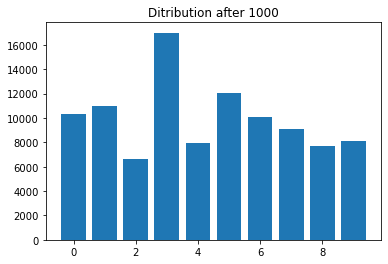

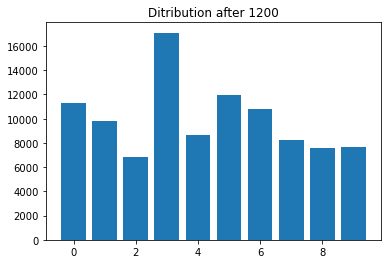

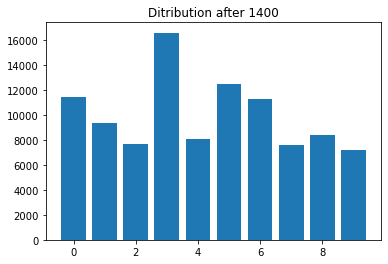

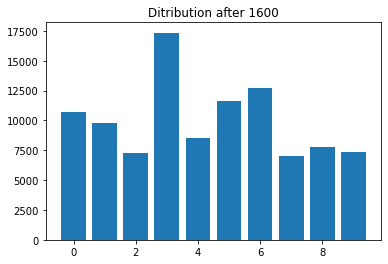

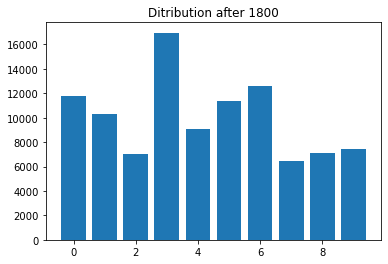

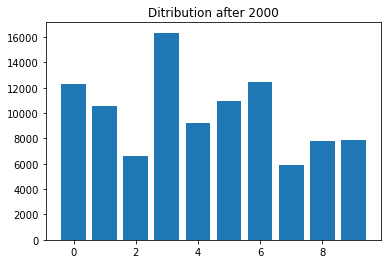

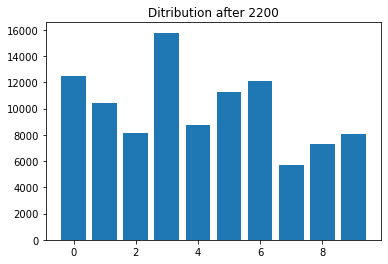

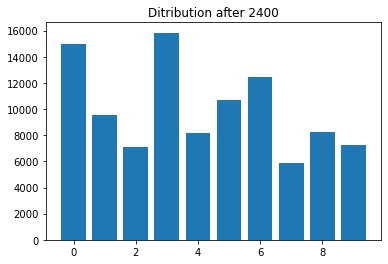

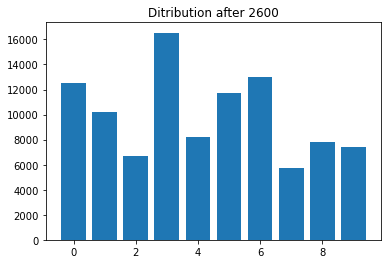

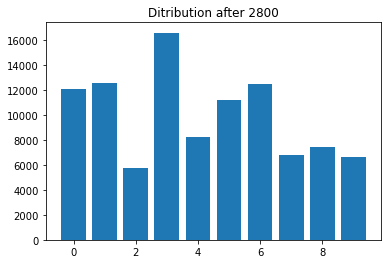

In [24]:
for sl_epoch in range(1, sl_epochs+1):
    # 构造新的source data
    test_loader = get_data_loader(test_dataset, mode = 'eval')
    pred_labels, pred_probs,_ = testing(feature_extractor, label_predictor, test_loader)
    idx = (pred_probs.max(axis=1) > threshold) & (pred_labels != 3)
    np.random.shuffle(idx)
    add_data, add_labels = test_loader.dataset.data[idx][:mix_num], pred_labels[idx][:mix_num]
    source_dataset = AddDataset(np.concatenate([source_x_paths, add_data]), np.concatenate([source_y, add_labels]), source_transform, target_transform)
    print(f'add : {len(add_data)} new source size: {len(source_dataset)}')
    source_loader = get_data_loader(source_dataset, batch_size=256, mode = 'train')
    target_loader = get_data_loader(target_dataset, batch_size=256, mode = 'train')
    test_loader = get_data_loader(test_dataset, batch_size=512, mode = 'eval')
    ## 画出分布
    labels_set, counts = np.unique(pred_labels,return_counts=True)
    fig = plot_distribution(pred_labels)
    fig.savefig(os.path.join(path, f'Ditribution after {total_epochs}_no3.png'), dpi = 300)
    fig.show()
    ## test
    df = pd.DataFrame({'id': np.arange(0,len(pred_labels)), 'label': pred_labels})
    df.to_csv(f'DaNN_submission_no3_{total_epochs}.csv',index=False)
    # train
    feature_extractor.train()
    label_predictor.train()
    domain_classifier.train()
    for epoch in range(total_epochs+1,total_epochs+ epochs+1):
        st = time.time()
        train_D_loss, train_F_loss, train_acc = train_epoch(source_loader, target_loader, lamb=0.1)
        ed = time.time()
        if epoch % 100 == 0:
            save_model(feature_extractor,  f'extractor_model_no3_{epoch}.bin')
            save_model(label_predictor, f'predictor_model_no3_{epoch}.bin')
            save_model(domain_classifier, f'domain_classifier_no3_{epoch}.bin')

            
        print('{:4.2f}s, epoch [{:0>3d}\{}]: train D loss: {:6.4f}, train F loss: {:6.6f}, acc {:6.6f}'.format(ed-st, epoch, epochs,  train_D_loss, train_F_loss, train_acc))
    total_epochs += epochs

In [ ]:
# 构造新的source data
test_loader = get_data_loader(test_dataset, mode = 'eval')
pred_labels, pred_probs,_ = testing(feature_extractor, label_predictor, test_loader)
idx = (pred_probs.max(axis=1) > threshold)
np.random.shuffle(idx)
add_data, add_labels = test_loader.dataset.data[idx][:mix_num], pred_labels[idx][:mix_num]
source_dataset = AddDataset(np.concatenate([source_x_paths, add_data]), np.concatenate([source_y, add_labels]), source_transform, target_transform)
print(f'add : {len(add_data)} new source size: {len(source_dataset)}')
source_loader = get_data_loader(source_dataset, mode = 'train')
target_loader = get_data_loader(target_dataset, mode = 'train')
test_loader = get_data_loader(test_dataset, mode = 'eval')

In [ ]:
## 画出分布
labels_set, counts = np.unique(pred_labels,return_counts=True)
fig = plot_distribution(pred_labels)
fig.savefig(os.path.join(path, f'Ditribution after {total_epochs}.png'), dpi = 300)
fig.show()

In [ ]:
# train
feature_extractor.train()
label_predictor.train()
domain_classifier.train()

epochs = 100

for epoch in range(total_epochs+1,total_epochs+ epochs+1):
    st = time.time()
    train_D_loss, train_F_loss, train_acc = train_epoch(source_loader, target_loader, lamb=0.1)
    ed = time.time()
    if epoch % 50 == 0:
        save_model(feature_extractor,  f'extractor_model_{epoch}.bin')
        save_model(label_predictor, f'predictor_model_{epoch}.bin')
        save_model(domain_classifier, f'domain_classifier_{epoch}.bin')

    print('source size {} {:4.2f}s, epoch [{:0>3d}\{}]: train D loss: {:6.4f}, train F loss: {:6.6f}, acc {:6.6f}'.format(len(source_loader.dataset), ed-st, epoch, epochs,  train_D_loss, train_F_loss, train_acc))
total_epoch += epochs

In [ ]:
import pandas as pd
#predict
pred_labels, pred_probs, latents = testing(feature_extractor, label_predictor, test_loader)
# save
df = pd.DataFrame({'id': np.arange(0,len(pred_labels)), 'label': pred_labels})
df.to_csv(f'DaNN_submission_{ex_name}.csv',index=False)